In [1]:
def recuperar_teor(idx):
    with open(diretorio + idx + ".txt", "r", encoding='utf-8') as f:
        contents = f.read()
    return contents

### Importação dos metadados

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
df = pd.read_csv("dados/corpus_tratado/metadados.csv")

### Filtrando os ids por assuntos

In [3]:
corte = 50
df_validos = pd.DataFrame(df.groupby("Assunto").size()).reset_index()
df_validos.columns = ["assunto", "quant"]
df_validos = df_validos.loc[df_validos.quant >= corte]
display(df_validos.quant.sum())
display(df_validos.assunto.nunique())
documentos_validos = df[df.Assunto.isin(df_validos.assunto)][["id", "Assunto"]].reset_index().drop('index', axis = 1)
documentos_validos

35027

125

,id,Assunto
0,1500075-43.2019.8.26.0569,Tráfico de Drogas e Condutas Afins
1,1019468-32.2019.8.26.0562,Alienação Fiduciária
2,0000043-68.2019.8.26.0616,Furto
3,1007259-02.2018.8.26.0292,DIREITO PREVIDENCIÁRIO
4,1000425-53.2019.8.26.0128,Rural (Art. 48/51)
...,...,...
35022,0001233-88.2018.8.26.0426,Cheque
35023,1514316-66.2019.8.26.0037,Impostos
35024,1008737-24.2019.8.26.0320,Indenização por Dano Material
35025,0000206-22.2019.8.26.0075,IPTU/ Imposto Predial e Territorial Urbano


### Separando grupos de treino e teste de maneira que as distribuições de assuntos permaneçam similares

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
X = documentos_validos.id
y = documentos_validos.Assunto
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_treino, X_teste = X[train_index], X[test_index]
    y_treino, y_teste = y[train_index], y[test_index]

TRAIN: (28021,) TEST: (7006,)


### Instanciando o corpus do conjunto de treinamento

In [5]:
from tqdm.notebook import tqdm
diretorio = "dados/corpus_tratado/"
X_treino = pd.DataFrame(X_treino)
X_treino['teores'] = [recuperar_teor(x) for x in tqdm(X_treino.id)]
X_treino['assunto'] = y_treino
X_treino.shape

(28021, 3)

#### ICA

In [27]:
from tqdm.notebook import tqdm
lista_tuplas = []
df_assuntos = pd.DataFrame()
for classe in tqdm(X_treino['assunto'].unique()):
    concat = ' '.join(X_treino.loc[X_treino['assunto'] == classe].teores)
    df_assuntos = pd.concat([df_assuntos, pd.DataFrame([(classe, concat)])], ignore_index = True)
df_assuntos.columns = ['assuntos', 'teores']

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
stopwords = nltk.corpus.stopwords.words('portuguese')
df_assuntos['teores'] = df_assuntos.teores.str.replace('\n', ' ').str.strip()
vectorizer = TfidfVectorizer(stop_words = stopwords, max_df = 50, smooth_idf = False)
vec = vectorizer.fit(df_assuntos.teores)
vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=50, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False,
                stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                            'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                            'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                            'ao', 'ele', 'das', 'à', 'seu', 'sua', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(list(zip([k for k, v in vec.vocabulary_.items()], vec.idf_)), columns = ['termo', 'idf']).sort_values(by='idf', ascending = False)
df

,termo,idf
68615,iinformou,5.828314
56936,faina,5.828314
29187,celebrantes,5.828314
29188,pouquíssima,5.828314
56934,constituintes,5.828314
...,...,...
19736,amuamento,1.916291
6604,captados,1.916291
55094,ressocializador,1.916291
1056,sylvia,1.916291


In [99]:
vec.

,cont,idf
count,72830.00000,72830.000000
mean,36515.50000,4.247102
std,21024.35439,1.124297
min,101.00000,1.000000
25%,18308.25000,3.639057
50%,36515.50000,4.737670
75%,54722.75000,5.143135
max,72930.00000,5.143135


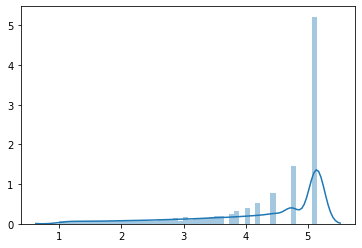

In [96]:
sns.distplot(df.idf.values)
plt.show()

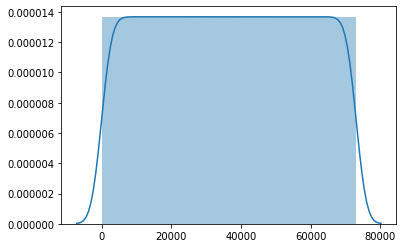

In [78]:
sns.distplot(df.cont.values)
plt.show()

In [80]:
df.cont.values

array([36092,  2354, 28784, ..., 71345,  7806, 70661], dtype=int64)